# Time Series Analysis - S&P 500 Index - 10 years 

The main goal of the Capstone Project is the evaluation of hybrid and stand-alone time-series predictive models using stock market data, such as SARIMA and Neural Networks (NN). 
In order to develop such models, the work will be carried by performing an analysis and meeting models requirements and assumptions. In addition, any pre-processing step or transformations would be exactly the same for all, focusing on consistency and fairness across every approach when comparing the results.   

**The present and first Jupyter will be composed by**: 

- Importing the data from Yahoo Finance; 
- Pre-Processing;
- EDA;
- Time Series Analysis; 


In [2]:
# Importing the necessary libraries for the project. 
import pandas as pd 
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
from scipy import stats
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings # filter warnings
warnings.filterwarnings('ignore')

The selected source is Yahoo Finances:

- Integration with Python;
- Open-Source data;
- Reliable Source;

The proposed period for the analysis in the project is 10 years of daily data. 

In [4]:
# Defines ticker symbol for S&P 500 index.
ticker_symbol = "^GSPC"

# Fetch historical data.
sp500_data = yf.download(ticker_symbol, start="2013-12-31", end="2023-12-31")

[*********************100%%**********************]  1 of 1 completed


# First Stage of Pre-Processing and EDA

- The analysis will be carried out using the closing index of the trading day.

In [6]:
# Selecting only the Close column (closing prices).
df = sp500_data['Close']

In [7]:
df.info() # Features and Info of the dataset.

<class 'pandas.core.series.Series'>
DatetimeIndex: 2517 entries, 2013-12-31 to 2023-12-29
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
2517 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [8]:
df.head() # First five rows of the dataset.

Date
2013-12-31    1848.359985
2014-01-02    1831.979980
2014-01-03    1831.369995
2014-01-06    1826.770020
2014-01-07    1837.880005
Name: Close, dtype: float64

In [9]:
df.shape # Shape of the dataset (rows X columns). 

(2517,)

- The dataset, a time-series data, is composed by the Date (Datetime Index) and the Close (daily closing index). The series presents 2517 observations. 

In [11]:
df.describe() # Descriptive Statistics of the closing index.

count    2517.000000
mean     3005.423258
std       901.454132
min      1741.890015
25%      2124.199951
50%      2798.030029
75%      3906.709961
max      4796.560059
Name: Close, dtype: float64

- Further comments on statistical properties will be given after imputation technique. 

In [13]:
# Check for missing values.
missing_values = df.isnull().sum()

# Print the number of missing values for each column.
print("Missing values:")
print(missing_values)

Missing values:
0


- As the count of statistics was the same as the number of observations, no missing values at this stage.  

In [15]:
# Check the frequency of the time series.
frequency = pd.infer_freq(df.index)

print("Frequency of the time series:", frequency) # Prints the frequency of the series.

Frequency of the time series: None


No frequency was detected in the time-series, thus business days ('b') will be the selected, due to the needs of the project.  
- Aligns with the chacteristics of the data (Stock market data), which is only open on business days. 


In [17]:
df = df.asfreq('b') # Sets the frequency to business days.

- Without any frequency, the original set did not included holidays and by setting to business days, it will generate nan values. 

In [19]:
# Check for missing values.
missing_values = df.isnull().sum()

# Print the number of missing values for each column.
print("Missing values:")
print(missing_values)

Missing values:
92


- After setting the new frequency, the series presents 92 missing values (number of holidays throughout 10 years of interval).

In [21]:
# Checking if there's any consecutive missing values in the Close indexes. 
# Converting NaN checks to integers (1 for True, 0 for False).
nan_series = df.isna().astype(int)

# Rolling window size 3 and sum to identify consecutive NaNs.
consecutive_nans = nan_series.rolling(window=3).sum() == 3

# Check for any occurrence of more than two consecutive NaNs.
has_consecutive_nans = consecutive_nans.any()

print(f"Two consecutive NaNs in 'Close' column? {has_consecutive_nans}")

Two consecutive NaNs in 'Close' column? False


- Between the period of 10 years, 92 holidays were added (no values).
- No consecutive missing values (two holidays in a sequence does not exists). 
- Assuming that the close value of the last trading day will maintain until the following trading day.

Many options can be applied to fill the missing values (holidays) and each one of them have a trade off of pros and cons. Techniques using the next opening day to fill the previous, linear regression and others (depending on the performance). The selected approach to handle the missing values is the foward fill and the reasons relies on:

The S&P500 index does not suffers any change when the market is closed;
- It can reduce the amount of noise by not adding artificial data;
- It represents more accurate real-world scenario;

Other options such as back-fill using the open index of the next day could be considered. On one hand can present events that might impact the stock market, on the other hand it can introduce bias to the models, by "seing" future data.

In [23]:
# Forward fill NaN values in the 'Close' column.
df.fillna(method='ffill', inplace=True)

# Display the updated DataFrame with forward filled values.
display(df)

Date
2013-12-31    1848.359985
2014-01-01    1848.359985
2014-01-02    1831.979980
2014-01-03    1831.369995
2014-01-06    1826.770020
                 ...     
2023-12-25    4754.629883
2023-12-26    4774.750000
2023-12-27    4781.580078
2023-12-28    4783.350098
2023-12-29    4769.830078
Freq: B, Name: Close, Length: 2609, dtype: float64

In [24]:
# Check for missing values.
missing_values = df.isnull().sum()

# Print the number of missing values for each column.
print("Missing values:")
print(missing_values)

Missing values:
0


- After applying the forward-fill, the previous code shows that it was sucessfull, resulting in zero missing values. 

In [26]:
# Get summary statistics
summary_stats = df.describe()

# Find the date of highest and lowest close price
peak_date = df.idxmax()
lowest_date = df.idxmin()

# Calculate monthly returns
monthly_returns = df.resample('M').ffill().pct_change().dropna()

# Output of metrics.
print("Summary Statistics:\n", summary_stats)
print("Peak Close Price Date:", peak_date, "Value:", df[peak_date])
print("Lowest Close Price Date:", lowest_date, "Value:", df[lowest_date])

Summary Statistics:
 count    2609.000000
mean     3005.472863
std       901.733128
min      1741.890015
25%      2124.199951
50%      2793.899902
75%      3902.620117
max      4796.560059
Name: Close, dtype: float64
Peak Close Price Date: 2022-01-03 00:00:00 Value: 4796.56005859375
Lowest Close Price Date: 2014-02-03 00:00:00 Value: 1741.8900146484375


The statistical properties of the index suffered small changes compared to the scale of the data.

- Count: Originally the dataset was composed by 2517 rows and had an increased of 92, totalizing 2609 observations. 
- Mean: After the imputation the mean increased only 0.049 (3005.47), indicating that the central tendency did not suffer any change. 
- Standard Deviation (std): After handling the missing values, the std was not impacted (increased of 0.27). Also, the value 901.7 indicates that the index shows significant variability.

Between the years of collected data, the highest recorded index was in 3 of January of 2022 at 4796.56 and the lowest in 3 of February of 2014 at 17.41.89.

In [28]:
# Filter and display the specified rows by their date
rows_to_display = df.loc[['2014-01-28', '2014-01-29', '2014-01-30', '2014-01-31', '2014-02-03']]

# Display the selected rows
print(rows_to_display)


Date
2014-01-28    1792.500000
2014-01-29    1774.199951
2014-01-30    1794.189941
2014-01-31    1782.589966
2014-02-03    1741.890015
Name: Close, dtype: float64


## S&P500 Visual Analysis

Statistical features along with visualizations will be generated to deepen the analysis. 
First the the observations will be extracted from the "original format" of the S&P500 index and later percentage change will be used to enhance the examination. In addition, pct change will help analysing the series volatility. 

In [30]:
# A copy will be created in a dataframe format to help the generation of plots.
# Creates a copy and converts the Series to a DataFrame.
df1 = df.to_frame()

# Creates a year column for grouping.
df1['Year'] = df1.index.year

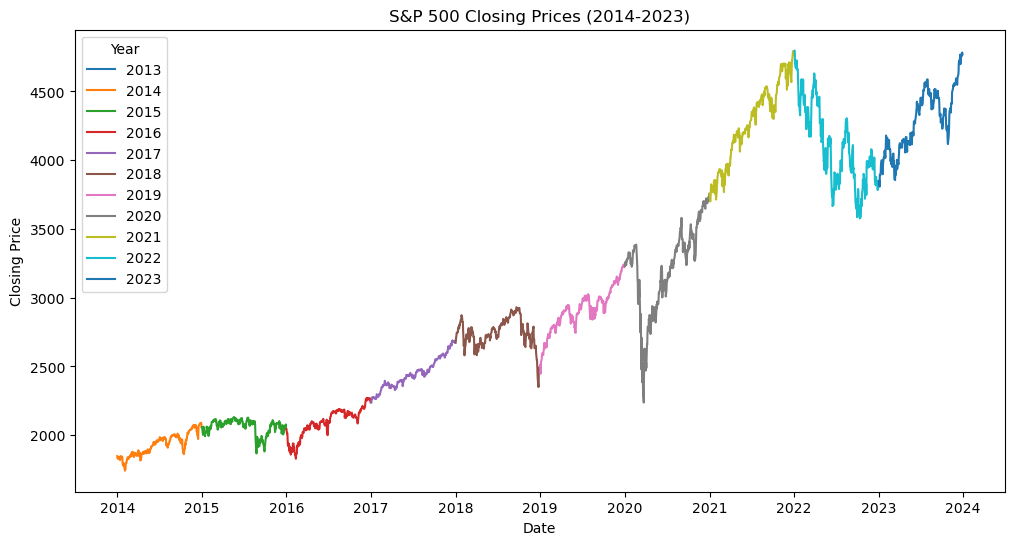

In [31]:
# Line Plot per Year
plt.figure(figsize=(12, 6)) # Sets fig size.
# Sets  the lineplot where the colors are based on the yeard, following the tab10 palette, providing clarity to the observer. 
sns.lineplot(data=df1, x=df1.index, y='Close', hue='Year', palette='tab10') 
plt.title('S&P 500 Closing Prices (2014-2023)') # Sets title.
plt.xlabel('Date') # Add label.
plt.ylabel('Closing Price') # Add label.
plt.legend(title='Year') # Adds legend (years). 
plt.show() # Display the fig. 

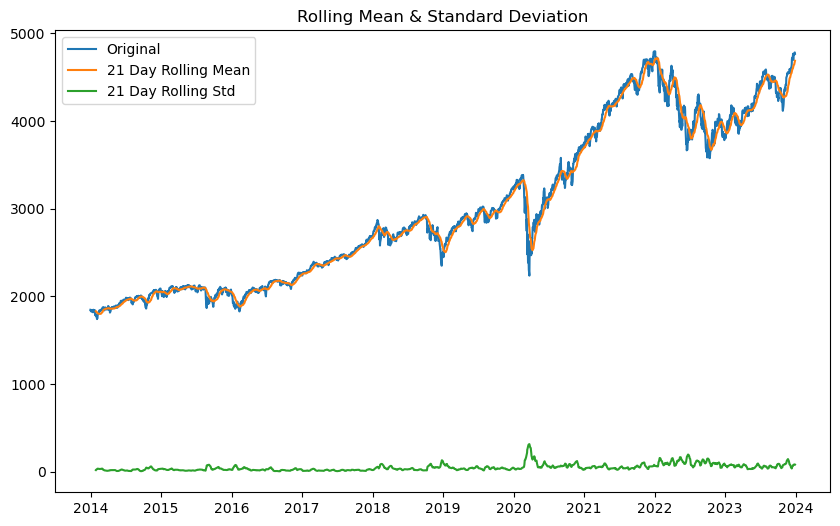

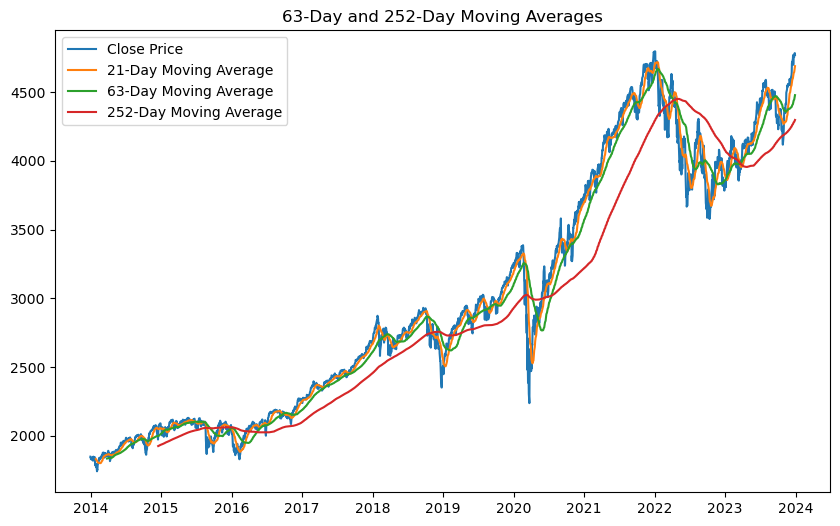

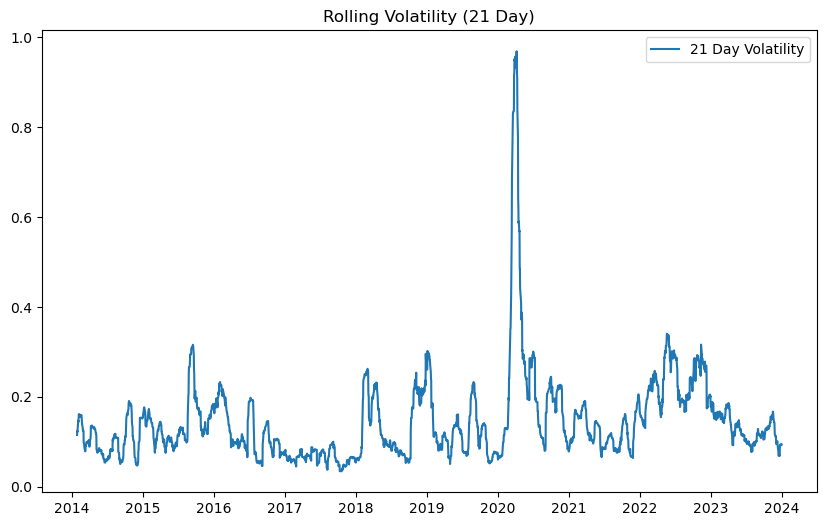

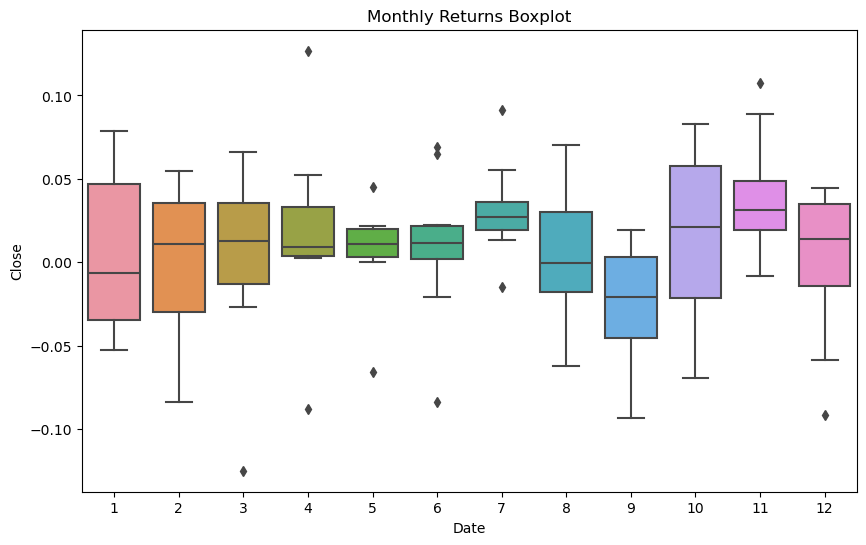

In [32]:
# Rolling Statistics and Moving Averages
rolling_mean_21 = df.rolling(window=21).mean()
rolling_std_21 = df.rolling(window=21).std()

# Long-term moving averages
rolling_mean_21 = df.rolling(window=21).mean()
rolling_mean_63 = df.rolling(window=63).mean()
rolling_mean_252 = df.rolling(window=252).mean()

# Volatility Analysis (Rolling volatility with a 30-day window)
volatility_21 = df.pct_change().rolling(window=21).std() * (252**0.5)  # Annualized volatility

# Seasonality Analysis (Monthly seasonality)
monthly_seasonality = df.groupby(df.index.month).mean()

# Visualizations

# Plotting rolling statistics
plt.figure(figsize=(10,6))
plt.plot(df, label='Original')
plt.plot(rolling_mean_21, label='21 Day Rolling Mean')
plt.plot(rolling_std_21, label='21 Day Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

# Plot moving averages
plt.figure(figsize=(10,6))
plt.plot(df, label='Close Price')
plt.plot(rolling_mean_21, label='21-Day Moving Average')
plt.plot(rolling_mean_63, label='63-Day Moving Average')
plt.plot(rolling_mean_252, label='252-Day Moving Average')
plt.title('63-Day and 252-Day Moving Averages')
plt.legend()
plt.show()

# Plot volatility
plt.figure(figsize=(10,6))
plt.plot(volatility_21, label='21 Day Volatility')
plt.title('Rolling Volatility (21 Day)')
plt.legend()
plt.show()

# Boxplot to detect outliers in monthly returns
plt.figure(figsize=(10,6))
sns.boxplot(x=monthly_returns.index.month, y=monthly_returns)
plt.title('Monthly Returns Boxplot')
plt.show()

Lineplot:
- The index presents an upward trend, the figures shows a long-term growth of the stocks. 
- In the recorded period, volatility is present, especially during crisis that can affect the economy (Health crisis started in 2019).
- The lineplot also does not show clear patterns. (indication of cyclical pattern, instead of seasonal).  

Rolling Statistics: 
- Shows a an upward trend with a huge dip during 2020 (Covid pandemic).

Rolling Volatility:
- It had a massive spike during the year of 2020 and returning to "normality" in the following year.
<b>- It could present great threat to forecasting models, periods with high volatility might cause bad performance.</b>

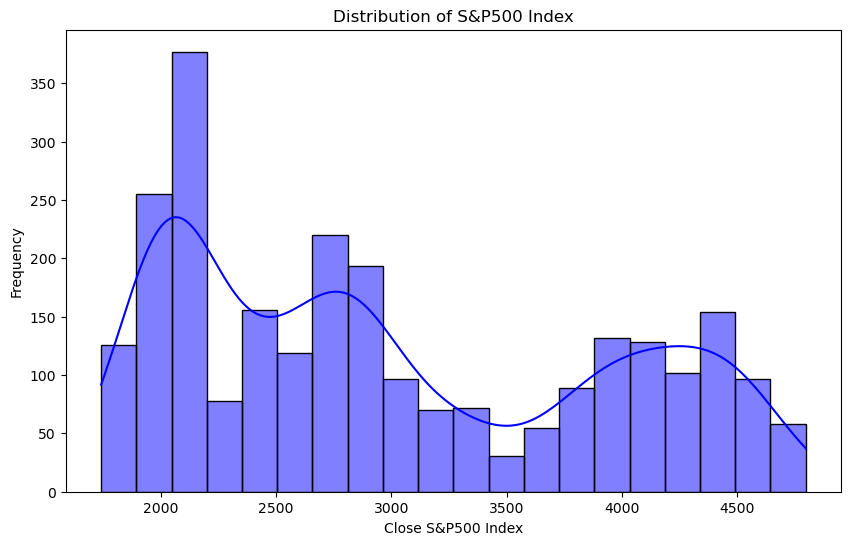

In [34]:
# Distribution plot of Close prices
plt.figure(figsize=(10, 6)) # Set fig size.
sns.histplot(df, bins=20, kde=True, color='blue') # Set bin size and color, add kde curve. 
plt.title('Distribution of S&P500 Index') # Add title.
plt.xlabel('Close S&P500 Index') # X-label.
plt.ylabel('Frequency') # Y-label.
plt.show() # Display the fig. 

- The histogram indicates that the index presents multimodal characteristics, where the KDE curve shows three different peaks. Despite trying different number of bins, multiple peaks were still present.
- During the recorded period, lower values (between 2000 and 3000) are more frequente than the higher values, indicating a right-skewed distribution.

**Obs**.: Models that follows the assumption that the data is normally distruibuted could present challenges. 

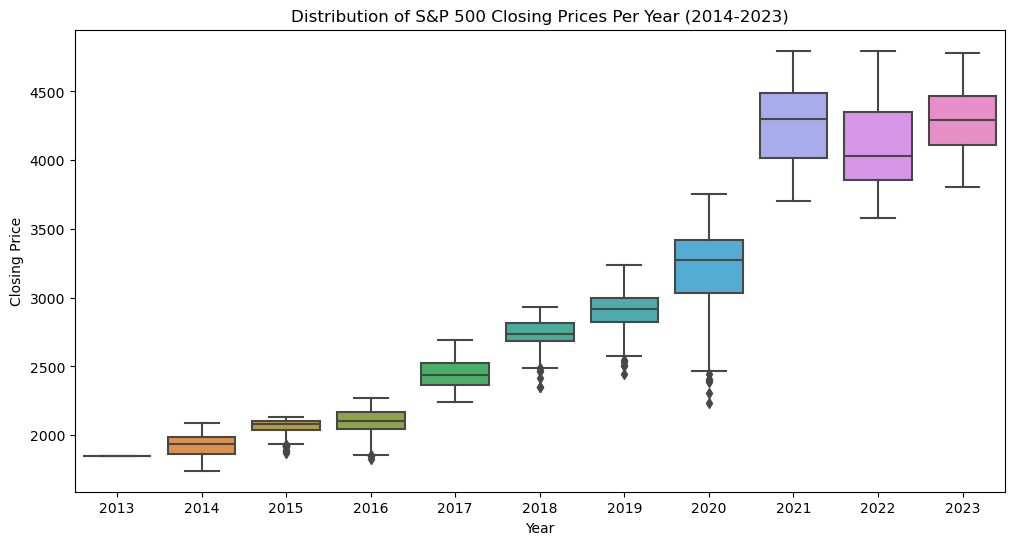

In [36]:
# Box Plot per Year
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Close', data=df1)
plt.title('Distribution of S&P 500 Closing Prices Per Year (2014-2023)')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.show()

The Boxplot per year shows that: 
- Like the lineplot it presents a upward trend. 
- The presence of outliers, especially in times of economical turmoil like the Covid Pandemic. High volatility.

**Note**: Outliers is a real threat for the models, the first attempt could be performed without any further processing step, just relying on techniques that would be applied in the forecasting models, such stationarity or scaling. In addition, if models performs badly, an extra step can be applied to reduce their impact.

### Seasonal Decomposition (Without transformation)

Both models, additive and multiplicative will be performed to check which one will better capture trends and seasonality (by observing the randomness of residuals. 

Seasonal Decomposition with Period = 126


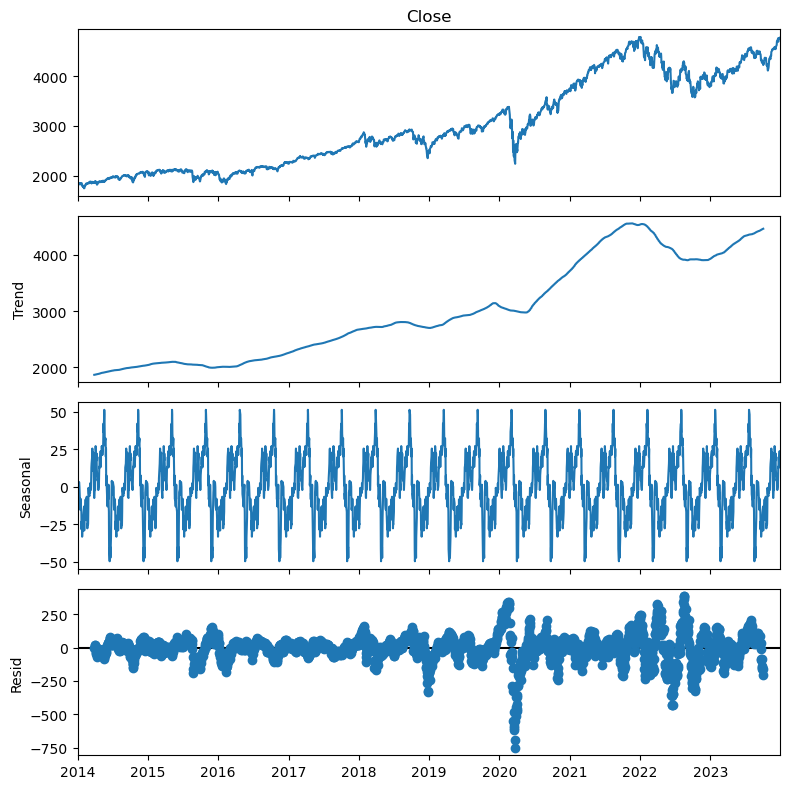

Seasonal Decomposition with Period = 63


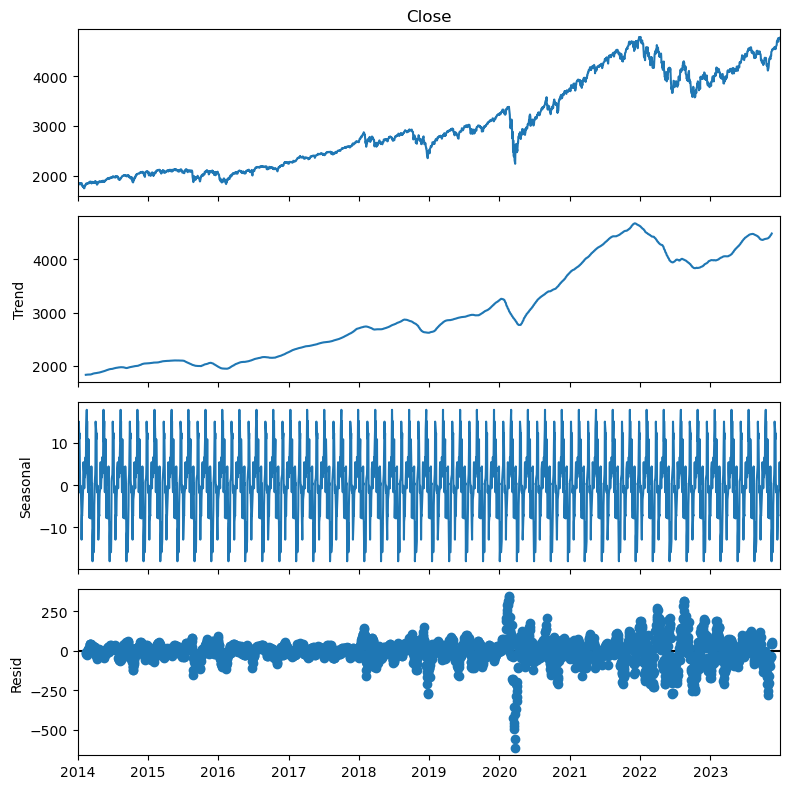

Seasonal Decomposition with Period = 21


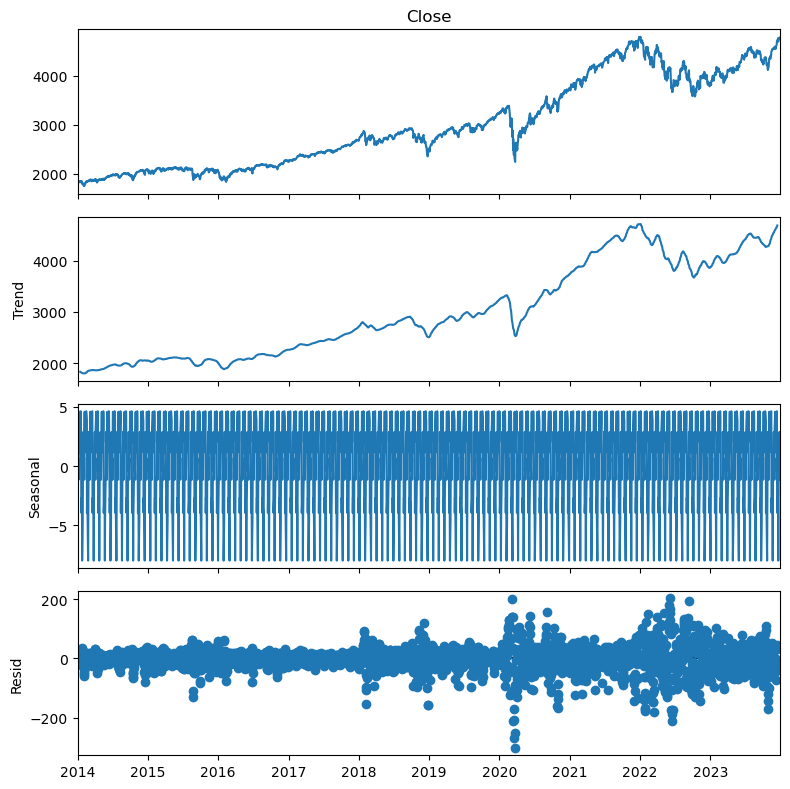

Seasonal Decomposition with Period = 5


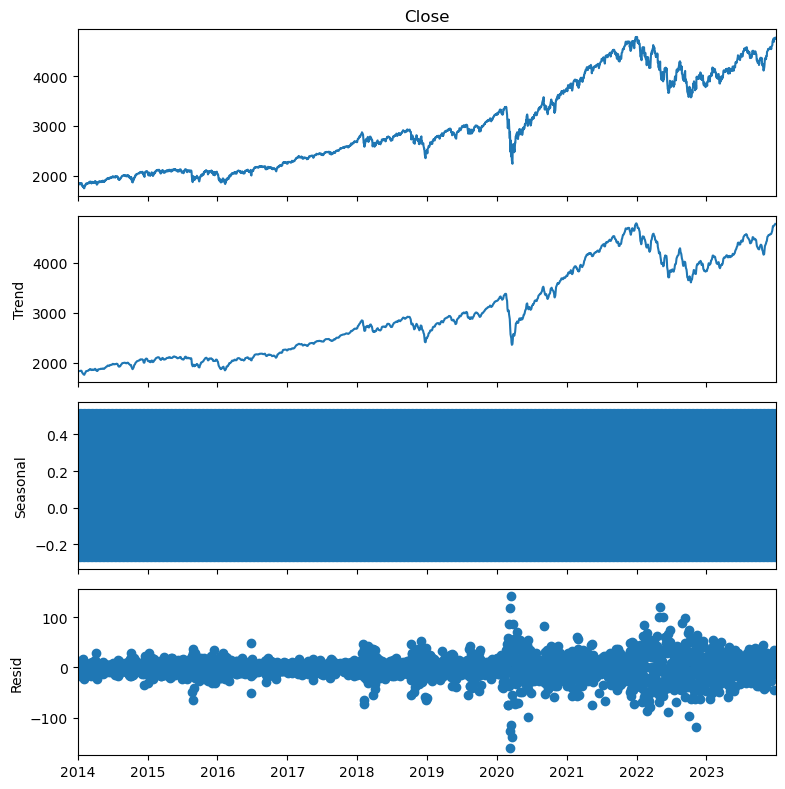

In [39]:
# Seasonal decompositions with different periods.
periods = [126, 63, 21, 5]  # Six months, Quarterly, Monthly, Weekly
# Function to generate the plots for all periods.
for period in periods:
    decompositions = seasonal_decompose(df, model='additive', period=period)

    # Plotting the components of the decomposition
    plt.rcParams.update({'figure.figsize': (8,8)})
    print(f"Seasonal Decomposition with Period = {period}")
    decompositions.plot()
    plt.show()

Seasonal Decomposition with Period = 126


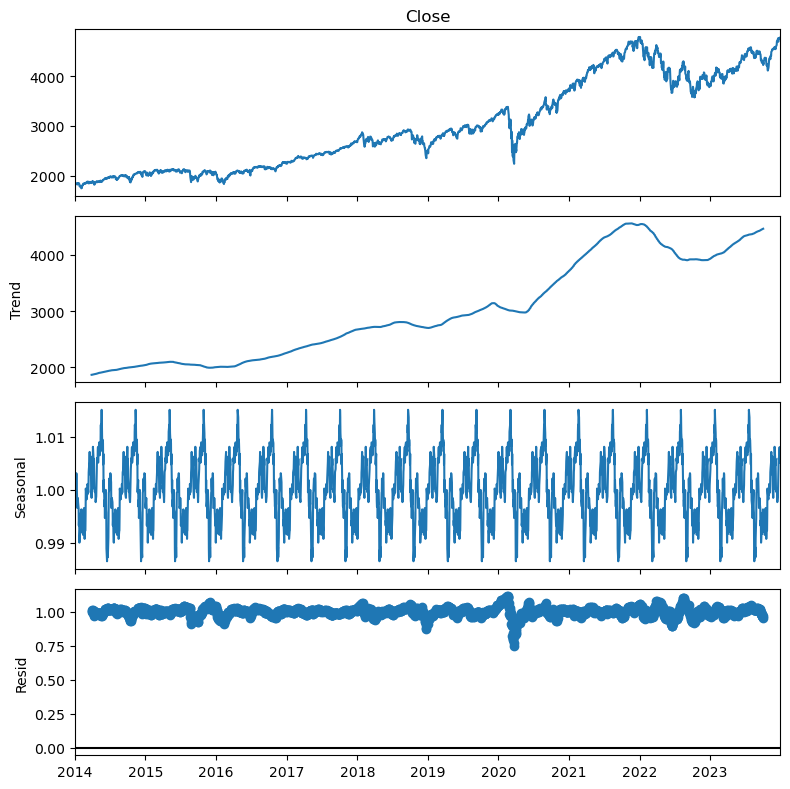

Seasonal Decomposition with Period = 63


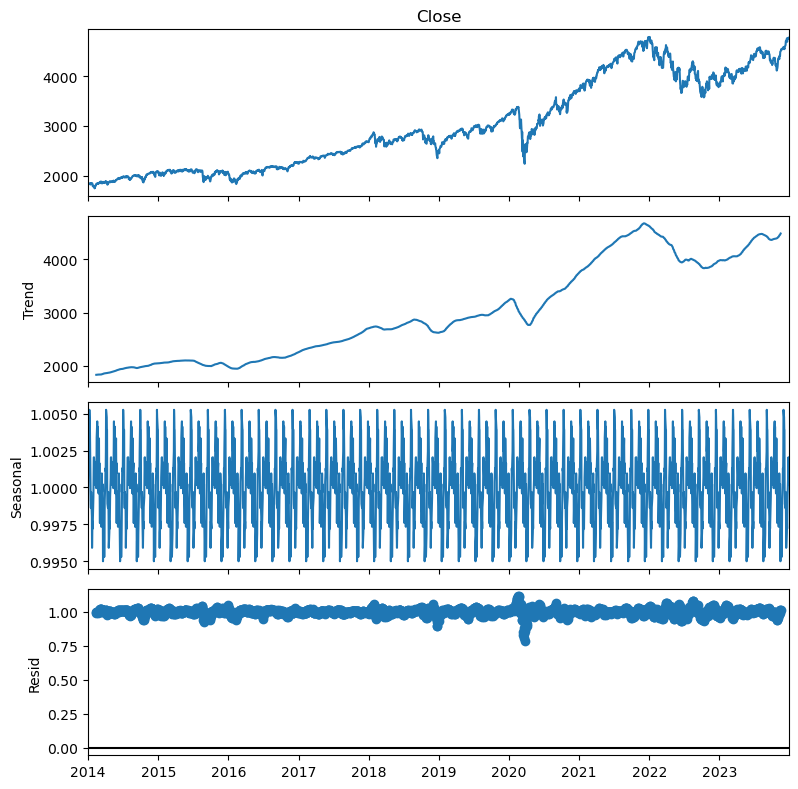

Seasonal Decomposition with Period = 21


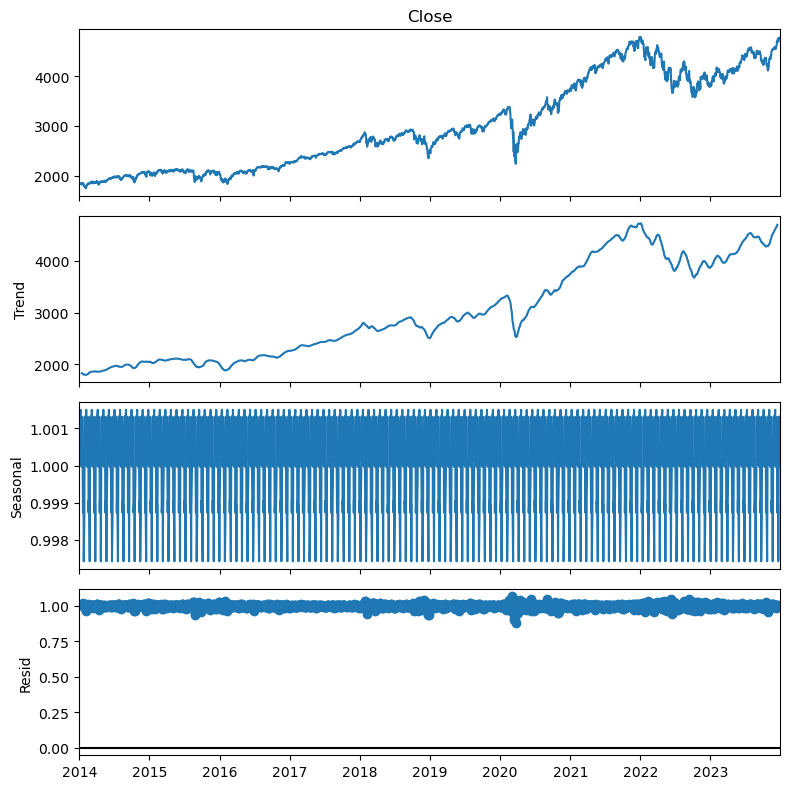

Seasonal Decomposition with Period = 5


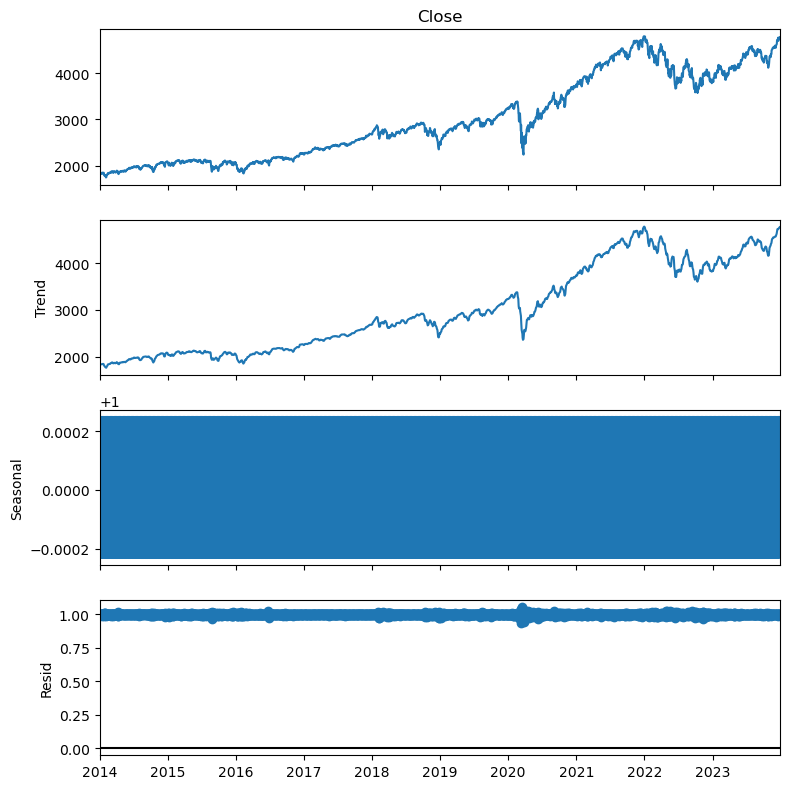

In [40]:
# Seasonal decompositions with different periods.
periods = [126, 63, 21, 5]  # Six months, Quarterly, Monthly, Weekly
# Function to generate the plots for all periods.
for period in periods:
    decompositions = seasonal_decompose(df, model='multiplicative', period=period)

    # Plotting the components of the decomposition
    plt.rcParams.update({'figure.figsize': (8,8)})
    print(f"Seasonal Decomposition with Period = {period}")
    decompositions.plot()
    plt.show()

According to the seasonal decompose (additive and multiplicative): 

- Both models shows a clear upward trend, indicating constant growth overtime, but presenting big drops, like when Covid-19 appeared (external events). 
- Seasonal variations is also observable when applying the multiplicative model. So, indicating that the seasonal variation of the S&P500 is not constant throughout time, but it might change proportionaly with the series. 
- Residuals in the multiplicative approach is less random and more aligned with the axis 1. Meanwhile, the additive has the residuals less aligned with its zero axis. Thus, the multiplicative method was able to better capture the trend and seasonal effects than the additive. 

Therefore, the decomposition of the series were better represented byt the multiplicative approach, meaning that more complex models like neural networks that could capture seasonal variations and likely yielding better performance.   

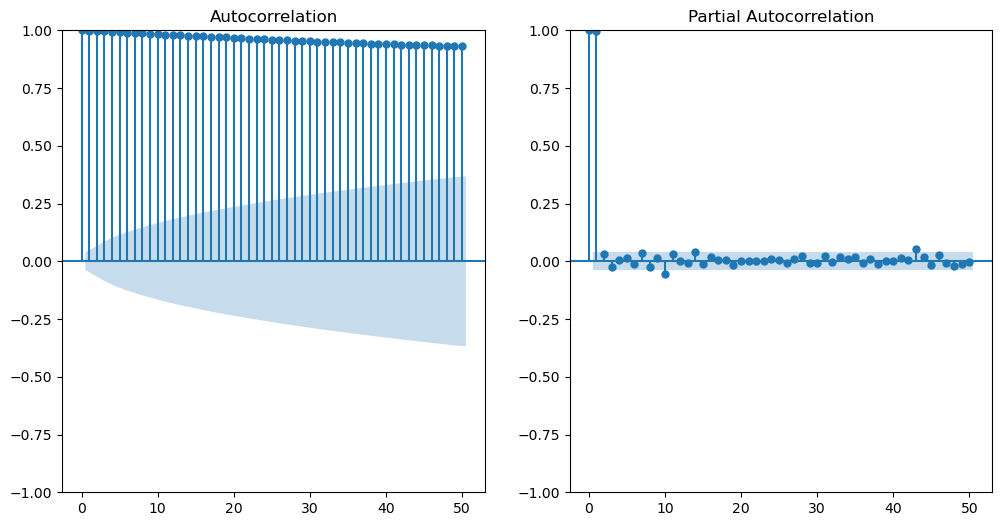

In [42]:
# ACF and PACF of log returns
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df, ax=plt.gca(), lags=50) # sets the acf plot. 
plt.subplot(122)
plot_pacf(df, ax=plt.gca(), lags=50) # sets the pacf plot. 
plt.show() # shows the plots

- The ACF correlation plot shows a strong correlation between its past values, in which can indicate that the series might not be stationary, because of the depency of previous values.
- The PACF shows that after the second lag the it drops to the confidence of interval. This information would be for auto-regressive models, where its order could be initially tested at 1 or 2.  

In [44]:
# ADF Test
result = adfuller(df, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.274939693479533
p-value: 0.9289793936532919
Critial Values:
   1%, -3.4328724587241686
Critial Values:
   5%, -2.862654426799674
Critial Values:
   10%, -2.567363249505311

KPSS Statistic: 7.951934
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


Both tests shows that the series is not stationary. The ADF test determined that the p-value is way above 0.05, so as the critical value is greater than the 10, 5 and 1%. The KPSS test also shows the the statistic value is way above the others and the p-value has a low value of 0.01. Therefore, to perform time series forecasting, the index will have to be transformed to achieve stationarity.
A couple of techniques will be applied (this is the case of autoregressive models, Neural Networks are able  to handle non-stationary data): 
- Log Returs: A model that is additive over time (a positive point for financial data) and has great chances to achieve stationarity. 
- Seasonal Differencing: With seasonal patters, the approach will attempt to remove seasonal patterns to achieve the objective. 


The approches will be evaluated in the forecasting stage, pointing which one has the lower metric scores. In addition, looking at consitency the data and pre-processing steps will be the same as performed in the present analysis. 

# Second Stage of Pre-Processing and EDA 

Before applying any other transformation, it was identified through tests (Notebook: Log Returns NN's or Log Returns ML) that the models are overfitting and this could be the high volatility and the presence of outliers.
Thus, winsorization is a technique that will cap extreme values. The "cut-off" values can be set through its quantile parameters and in the case of this project the chosen values will be 0.1 and 0.9, an agressive selection due to the high number of outliers. 

In addition, it was noticed that 2020:
- Is an "extreme" year, where its volatility is very high.
- If winsozisation is applied using the quantiles of the entire dataset the values of 2020 will not be "adjusted properly", because the values of the year fall between the 0.1/0.9 setting.

Therefore, the approach will be applied using the quantiles per year and later saved to be tested if the technique has any impact dealing with outliers and possibly volatility.  

In [47]:
# Ensure your 'Year' column is correctly extracted from the index
df1['Year'] = df1.index.year

def winsorize_per_year(group):
    # Apply winsorization column by column
    for col in group.select_dtypes(include='number').columns:
        lower_limit = group[col].quantile(0.1)
        upper_limit = group[col].quantile(0.9)
        group[col] = group[col].clip(lower=lower_limit, upper=upper_limit)
    return group

# Apply to each year
capped_df = df1.groupby('Year').apply(winsorize_per_year)

# Remove the 'Year' column afterward if it's no longer needed
capped_df = capped_df.drop(columns='Year')

# Remove the 'Year' from the index and keep 'Date' as the primary index
capped_df = capped_df.reset_index(level='Year', drop=True)

# Display the winsorized DataFrame for verification
print(capped_df.head())

                  Close
Date                   
2013-12-31  1848.359985
2014-01-01  1848.359985
2014-01-02  1837.880005
2014-01-03  1837.880005
2014-01-06  1837.880005


In [48]:
capped_df.describe()

,Close
count,2609.000000
mean,3007.540278
std,896.142365
min,1837.880005
25%,2112.929932
50%,2793.899902
75%,3915.459961
max,4668.970215


By observing the statistical properties (before and after winsorization): 
- It shows that the approach reduced entreme values (Min and Max).
- Both, the mean and median stayed almost the same, indicating that the extreme values were not directly affecting the central tendency of the series.

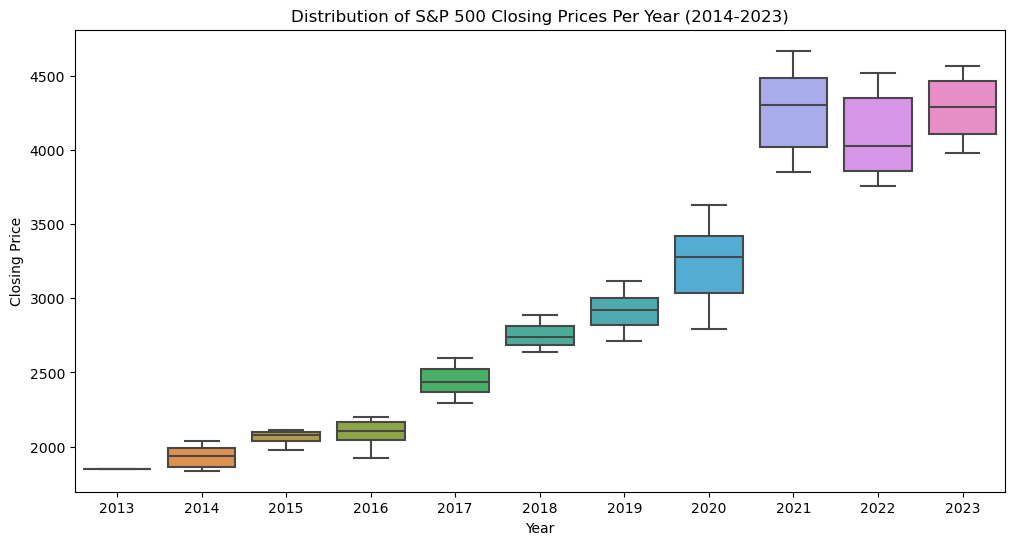

In [50]:
# Creates a year column for grouping.
capped_df['Year'] = capped_df.index.year
# Box Plot per Year
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Close', data=capped_df)
plt.title('Distribution of S&P 500 Closing Prices Per Year (2014-2023)')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.show()

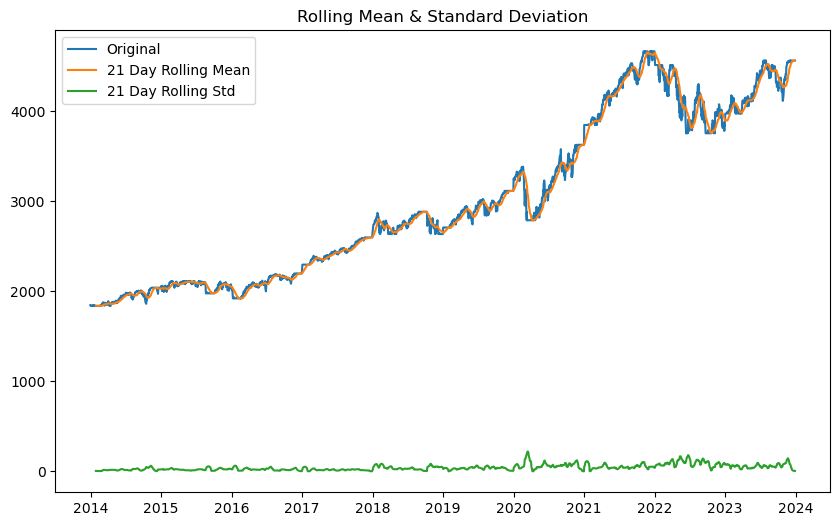

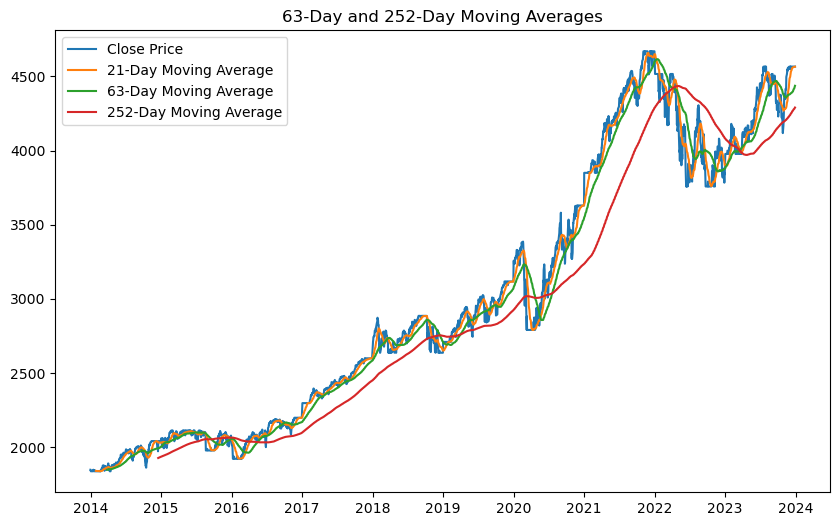

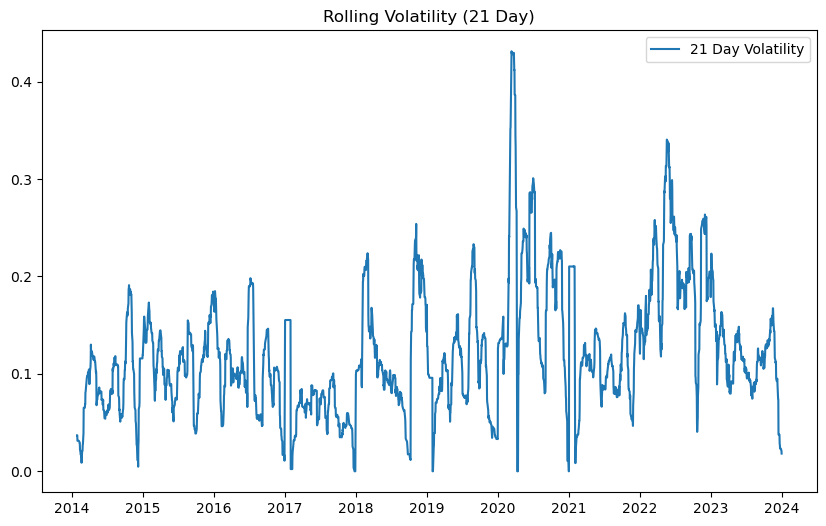

In [51]:
# Rolling Statistics and Moving Averages
rolling_mean_21 = capped_df['Close'].rolling(window=21).mean()
rolling_std_21 = capped_df['Close'].rolling(window=21).std()

# Long-term moving averages
rolling_mean_21 = capped_df['Close'].rolling(window=21).mean()
rolling_mean_63 = capped_df['Close'].rolling(window=63).mean()
rolling_mean_252 = capped_df['Close'].rolling(window=252).mean()

# Volatility Analysis (Rolling volatility with a 30-day window)
volatility_21 = capped_df['Close'].pct_change().rolling(window=21).std() * (252**0.5)  # Annualized volatility

# Visualizations

# Plotting rolling statistics
plt.figure(figsize=(10,6))
plt.plot(capped_df['Close'], label='Original')
plt.plot(rolling_mean_21, label='21 Day Rolling Mean')
plt.plot(rolling_std_21, label='21 Day Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

# Plot moving averages
plt.figure(figsize=(10,6))
plt.plot(capped_df['Close'], label='Close Price')
plt.plot(rolling_mean_21, label='21-Day Moving Average')
plt.plot(rolling_mean_63, label='63-Day Moving Average')
plt.plot(rolling_mean_252, label='252-Day Moving Average')
plt.title('63-Day and 252-Day Moving Averages')
plt.legend()
plt.show()

# Plot volatility
plt.figure(figsize=(10,6))
plt.plot(volatility_21, label='21 Day Volatility')
plt.title('Rolling Volatility (21 Day)')
plt.legend()
plt.show()

The plots from before and after winsoziration tells that:
- Boxplots shows that outliers were removed.
- The overall trend of the serives was not affected.
- Huge spike on 2020 was reduced.
- The volalility (21) was also impacted, the year of 2020 has no longer the huge spike. 

In [53]:
# Path to save to the Desktop
capped_df.to_csv('C:/Users/nozom/OneDrive/Desktop/Preprocessing Pipelines/df.csv', index=True)

# Third Stage of Pre-Processing and EDA 

- Feature Extraction will be performed (raw data) as part of data preparation in order to overcome overfitting problems when appling machine learning models.   

The engineerging will be applied on the raw data in order to capture the original features and later winsorization will be performed in the dataset to handle outliers. 

In [55]:
df1.describe()

,Close,Year
count,2609.000000,2609.000000
mean,3005.472863,2018.495975
std,901.733128,2.873229
min,1741.890015,2013.000000
25%,2124.199951,2016.000000
50%,2793.899902,2018.000000
75%,3902.620117,2021.000000
max,4796.560059,2023.000000


- The code for volatility (Rolling Standard Deviation) was generating numerous NaN values and this could be due to the scale of the log returns. Thus, the Exponential Weighted Volatility will be used as variables. 

In [57]:
# Calculate moving averages and volatility before winsorization
df1['MA5'] = df1['Close'].rolling(window=5).mean()
df1['MA21'] = df1['Close'].rolling(window=21).mean()
df1['volatility_5_ewm'] = df1['Close'].ewm(span=5, adjust=False).std()
df1['volatility_21_ewm'] = df1['Close'].ewm(span=21, adjust=False).std()

# 5-day and 21-day Exponential Moving Averages
df1['EMA_5'] = df1['Close'].ewm(span=5, adjust=False).mean()
df1['EMA_21'] = df1['Close'].ewm(span=21, adjust=False).mean()

# 10-day Momentum (Rate of Change)
df1['momentum_10'] = df1['Close'].diff(10)

# Calculate log returns
df1['log_return'] = np.log(df1['Close'] / df1['Close'].shift(1))

# Technical indicators like RSI and MACD
delta = df1['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=10).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=10).mean()
rs = gain / loss
df1['rsi'] = 100 - (100 / (1 + rs))

# Display the DataFrame to check the results
display(df1)

,Close,Year,MA5,MA21,volatility_5_ewm,volatility_21_ewm,EMA_5,EMA_21,momentum_10,log_return,rsi
Date,,,,,,,,,,,
2013-12-31,1848.359985,2013,NaN,NaN,NaN,NaN,1848.359985,1848.359985,NaN,NaN,NaN
2014-01-01,1848.359985,2014,NaN,NaN,0.000000,0.000000,1848.359985,1848.359985,NaN,0.000000,NaN
2014-01-02,1831.979980,2014,NaN,NaN,9.637150,8.570291,1842.899984,1846.870894,NaN,-0.008901,NaN
2014-01-03,1831.369995,2014,NaN,NaN,9.744217,9.822076,1839.056654,1845.461721,NaN,-0.000333,NaN
2014-01-06,1826.770020,2014,1837.367993,NaN,10.184474,11.332573,1834.961109,1843.762476,NaN,-0.002515,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,4754.629883,2023,4744.545996,4646.183315,32.339236,120.567798,4742.122767,4654.779006,132.189941,0.000000,74.215073
2023-12-26,4774.750000,2023,4745.821973,4656.865211,31.510665,120.266654,4752.998511,4665.685460,131.049805,0.004223,74.106915
2023-12-27,4781.580078,2023,4762.467969,4667.659970,29.813861,119.644062,4762.525700,4676.221335,74.490234,0.001429,67.303190


In [58]:
# Check for missing values.
missing_values = df1.isnull().sum()

# Print the number of missing values for each column.
print("Missing values:")
print(missing_values)

Missing values:
Close                 0
Year                  0
MA5                   4
MA21                 20
volatility_5_ewm      1
volatility_21_ewm     1
EMA_5                 0
EMA_21                0
momentum_10          10
log_return            1
rsi                   9
dtype: int64


In [59]:
# Drop rows where any column has NaN values
df1 = df1.dropna()

# Check for missing values.
missing_values = df1.isnull().sum()

# Print the number of missing values for each column.
print("Missing values:")
print(missing_values)

Missing values:
Close                0
Year                 0
MA5                  0
MA21                 0
volatility_5_ewm     0
volatility_21_ewm    0
EMA_5                0
EMA_21               0
momentum_10          0
log_return           0
rsi                  0
dtype: int64


In [60]:
df1.describe()

,Close,Year,MA5,MA21,volatility_5_ewm,volatility_21_ewm,EMA_5,EMA_21,momentum_10,log_return,rsi
count,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000
mean,3014.529653,2018.531093,3012.230047,3003.308623,31.312924,60.316933,3012.242198,3003.472171,11.306790,0.000380,56.691074
std,899.277328,2.856211,898.082209,893.821794,25.242057,43.510426,897.855219,893.186294,101.500239,0.011035,19.467180
min,1741.890015,2014.000000,1760.950000,1800.866664,3.177438,12.736170,1762.357745,1797.492695,-732.020020,-0.127652,3.465427
25%,2129.899902,2016.000000,2127.952051,2115.002360,14.027321,29.205410,2132.008811,2126.881764,-23.039795,-0.003533,42.968944
50%,2801.310059,2019.000000,2796.084033,2786.494745,23.794287,49.630291,2795.048584,2782.583911,19.119995,0.000312,57.520115
75%,3910.520020,2021.000000,3912.220020,3891.190941,40.743908,78.060450,3912.827116,3899.201207,58.709961,0.005279,70.841278
max,4796.560059,2023.000000,4785.614062,4716.834775,236.990576,381.636844,4782.469879,4721.577117,426.280029,0.089683,97.913688


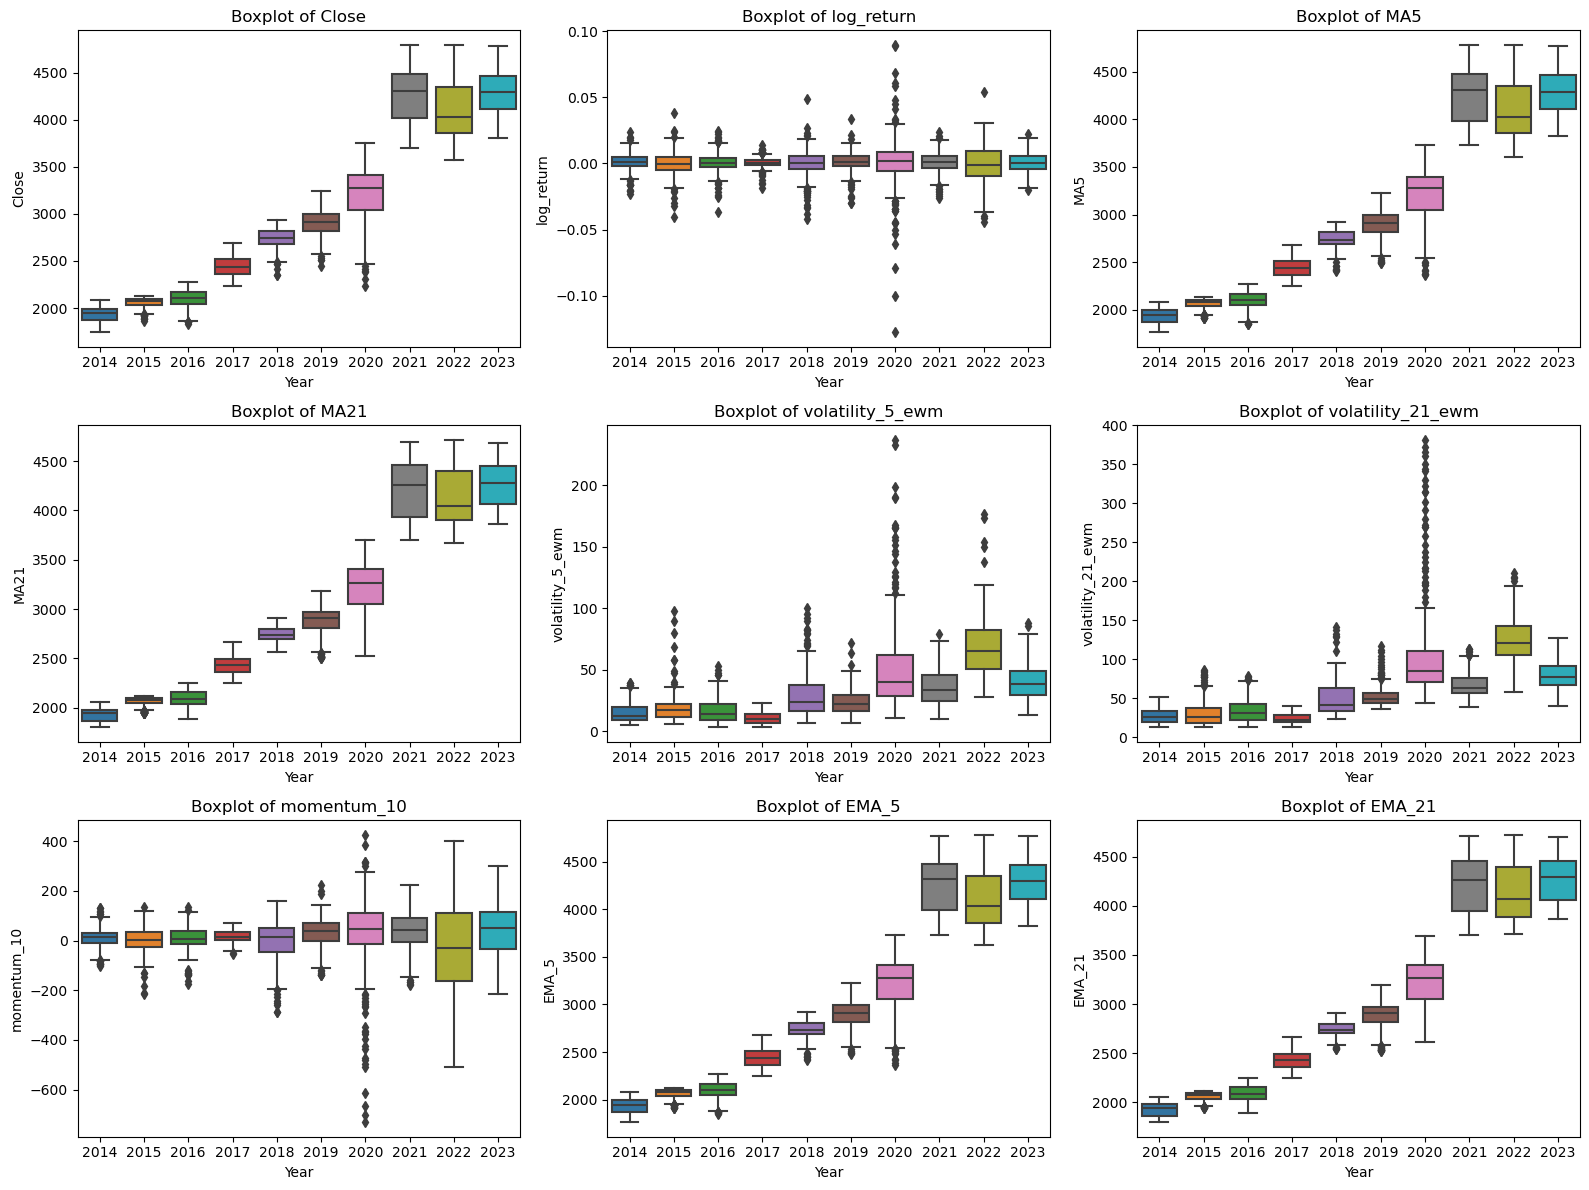

In [61]:
# List of features to check for outliers
features = ['Close', 'log_return', 'MA5', 'MA21', 'volatility_5_ewm', 'volatility_21_ewm', 'momentum_10', 'EMA_5', 'EMA_21']

# Create boxplots for each feature
plt.figure(figsize=(16, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i) # 3x3 grid for 9 features
    sns.boxplot(data=df1, x='Year', y=feature)
    plt.title(f'Boxplot of {feature}')
    
plt.tight_layout()
plt.show()

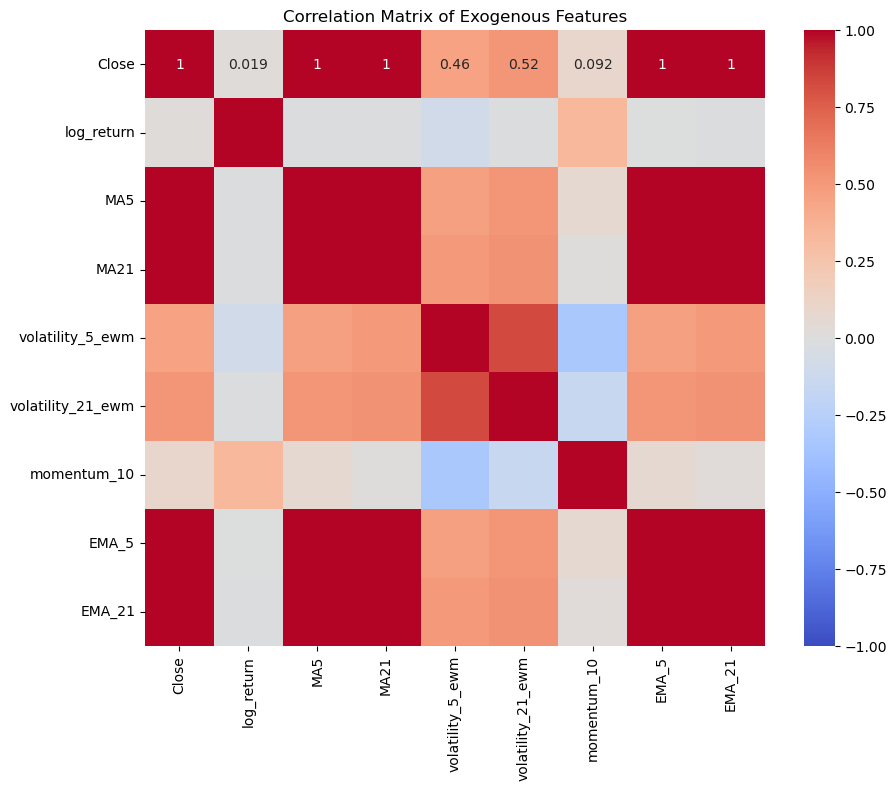

In [62]:
# Calculate the correlation matrix
correlation_matrix = df1[['Close', 'log_return', 'MA5', 'MA21', 'volatility_5_ewm', 'volatility_21_ewm', 'momentum_10', 'EMA_5', 'EMA_21']].corr()

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Exogenous Features')
plt.show()

In [63]:
# Calculate the correlation between features and the target (Close price)
feature_target_corr = df1[['Close', 'log_return', 'MA5', 'MA21', 'volatility_5_ewm', 'volatility_21_ewm', 'momentum_10', 'EMA_5', 'EMA_21']].corr()

# Display only the target's correlation with the other features
print(feature_target_corr['Close'])

Close                1.000000
log_return           0.019304
MA5                  0.999198
MA21                 0.995877
volatility_5_ewm     0.459635
volatility_21_ewm    0.516824
momentum_10          0.091721
EMA_5                0.999470
EMA_21               0.997091
Name: Close, dtype: float64


- The Variance Inflation Factor (VIF) will help the measure the level of multicollinearity among the features extracted from the series. It will show how strong or weak certain feature is correlated to other features.
The VIF values:
- Equal to one will have no multicollinearity.
- Between 1 and 5 will present moderate level. 
- Between 5 and 10 normally will indicate multicollinearity.
- Above 10 very strong.  

In [65]:
# Create a DataFrame for features only
features = df1[['Close', 'log_return', 'MA5', 'MA21', 'volatility_5_ewm', 'volatility_21_ewm', 'momentum_10', 'EMA_5', 'EMA_21']]

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = features.columns
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print(vif)

             Feature            VIF
0              Close  132201.155818
1         log_return       2.881763
2                MA5  391238.742270
3               MA21   63842.725183
4   volatility_5_ewm      10.126781
5  volatility_21_ewm      10.727875
6        momentum_10       7.533517
7              EMA_5  961338.665682
8             EMA_21   93567.239697


The VIF values of the dataset shows that: 
- Moving Averages (MA5, MA21, EMA_5 and EMA_21) will be naturally correlated with the S&P500 index (Close) and this is because they are derivered from indexes.
- Volatility has a high score of 10 (keeping both could be redundant for ML models.
- Log Returns: The calculation is based on the relative change of the index so it is less likely to be correlated with the Close values (Score that falls under "good" feature to be added to the model.
- Momentum: Another feature that has a score that presents a moderate level, which can be useful for models.

After analysing the correlation between the features: 
- Moving Averages: All of the features (MA5, MA21, EMA_5 and EMA_21) will be excluded from the set due to strong multicollinearity.
- Volatility: The (5 and 21) has similiar score but the (5) has a small difference, thus the (21) will also be excluded since they represent the same "indicator".
- Log Returns and Momentum are the feature with lowest levels of correlation, so they can be very useful for predicting models. 

In [67]:
# Keep only the necessary features
df1 = df1[['Year', 'Close', 'log_return', 'volatility_5_ewm', 'momentum_10']]

# Display the modified DataFrame
print(df1.head())

            Year        Close  log_return  volatility_5_ewm  momentum_10
Date                                                                    
2014-01-28  2014  1792.500000    0.006122         25.926020   -46.380005
2014-01-29  2014  1774.199951   -0.010262         26.095101   -74.180054
2014-01-30  2014  1794.189941    0.011204         21.309648   -51.700073
2014-01-31  2014  1782.589966   -0.006486         18.363369   -56.109985
2014-02-03  2014  1741.890015   -0.023097         29.465410   -96.809937


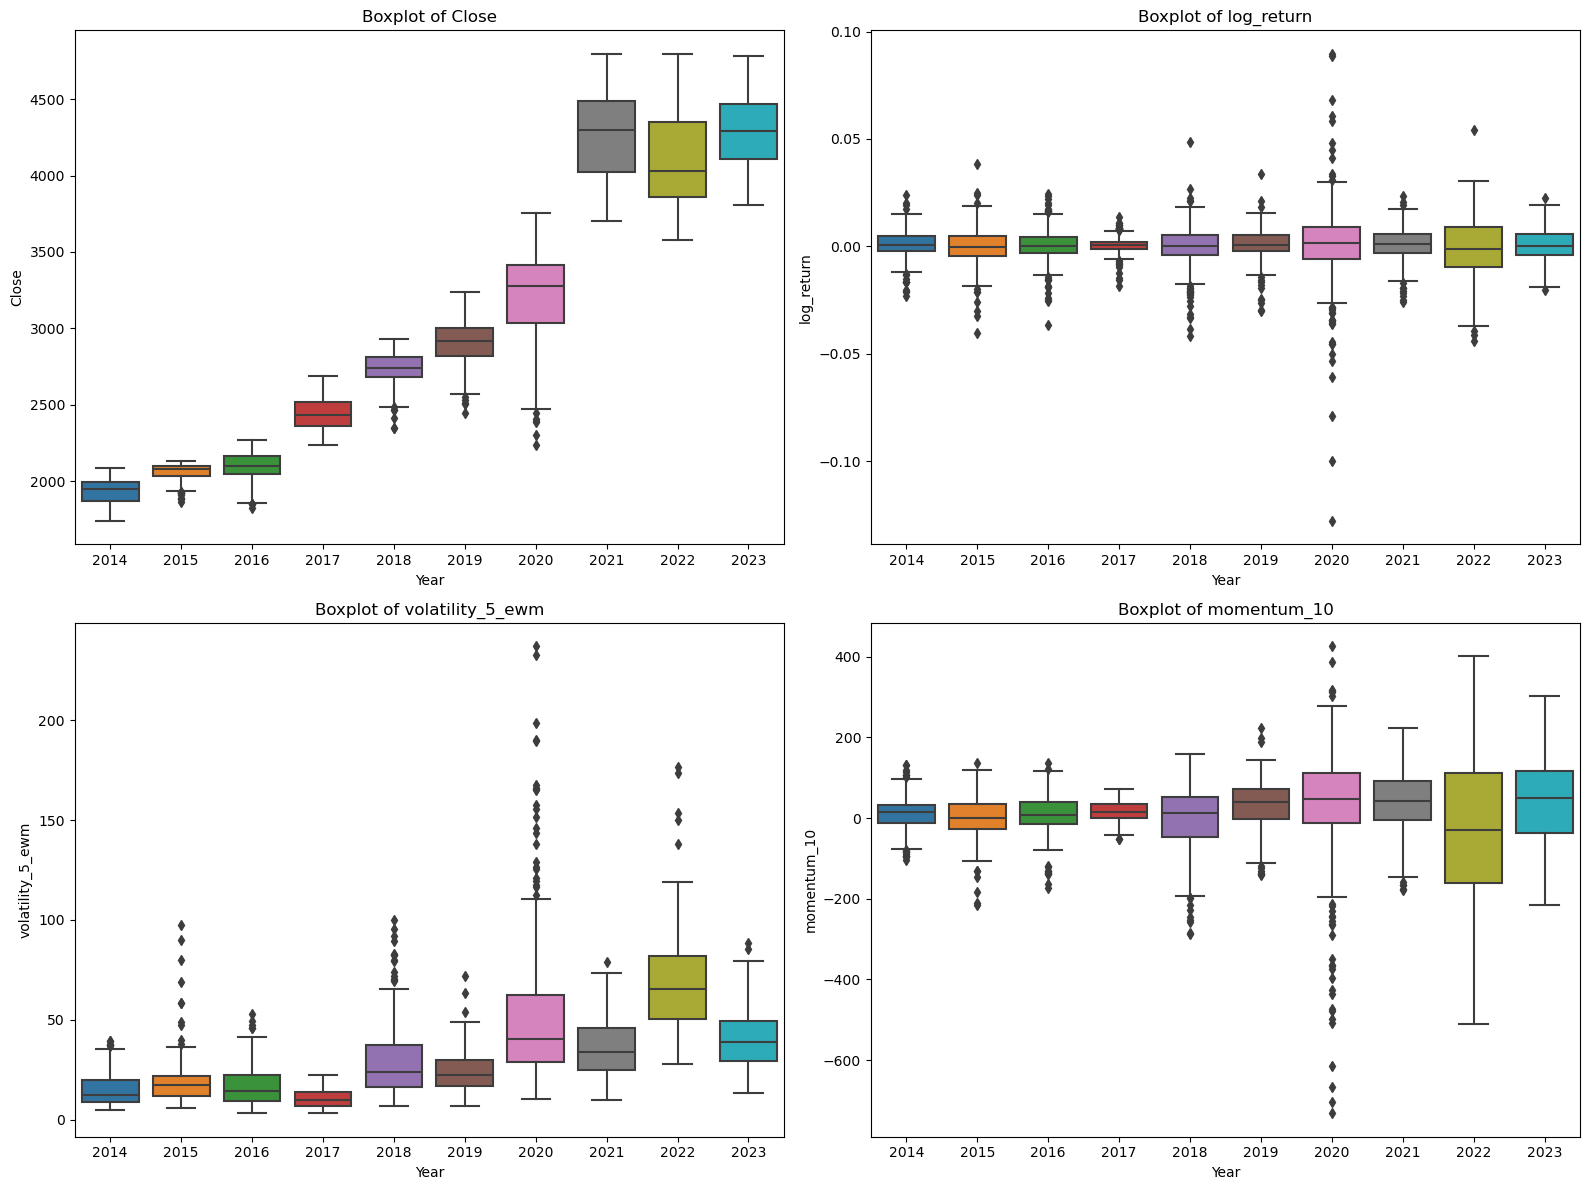

In [68]:
# List of features to check for outliers
features = ['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']

# Create boxplots for each feature
plt.figure(figsize=(16, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i) # 2x2 grid for 4 features
    sns.boxplot(data=df1, x='Year', y=feature)
    plt.title(f'Boxplot of {feature}')
    
plt.tight_layout()
plt.show()

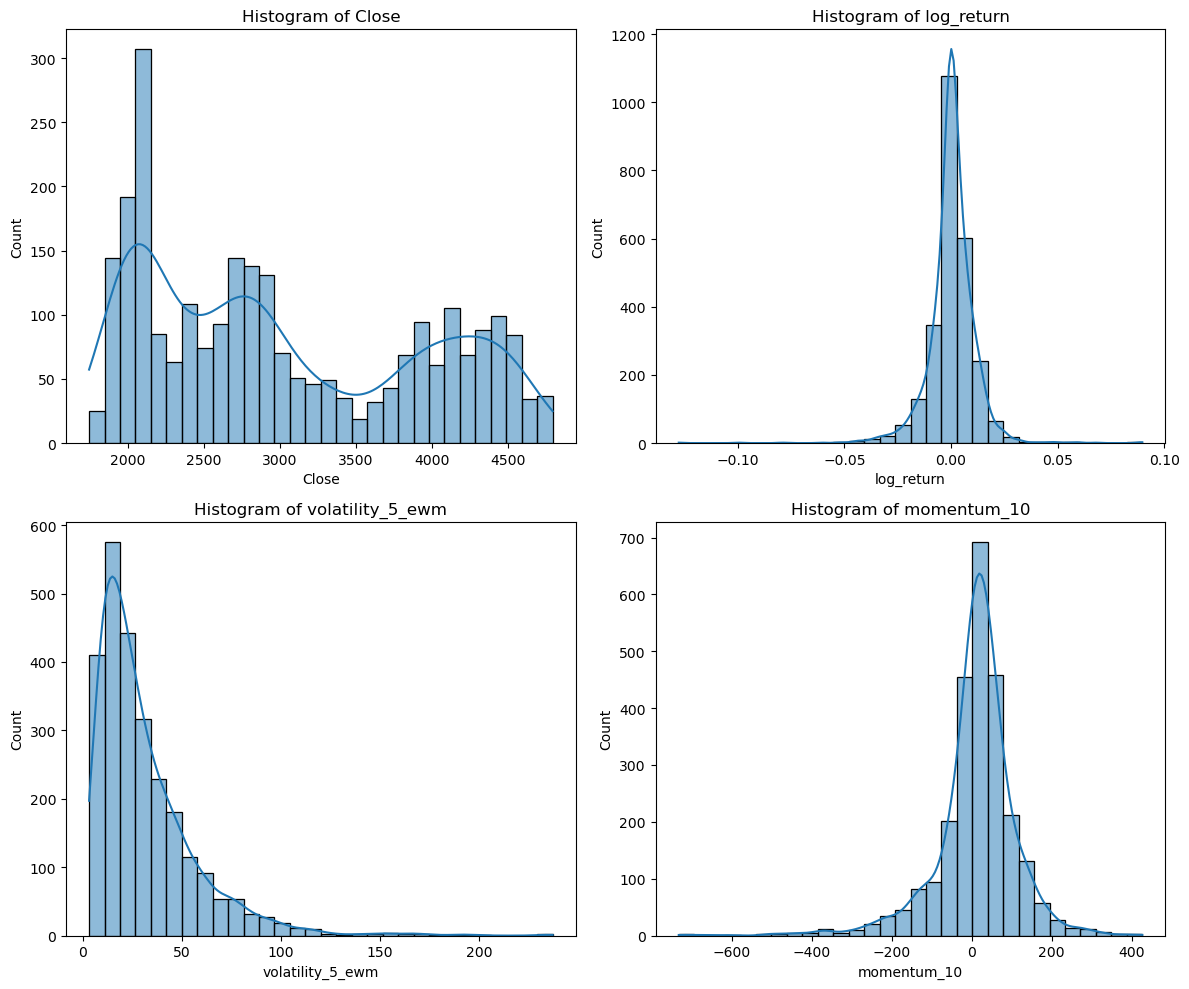

In [69]:
# List of features to plot histograms for
features = ['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']

# Plot histograms for each feature
plt.figure(figsize=(12, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)  # 2x2 grid for 4 features
    sns.histplot(df1[feature], bins=30, kde=True)
    plt.title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()

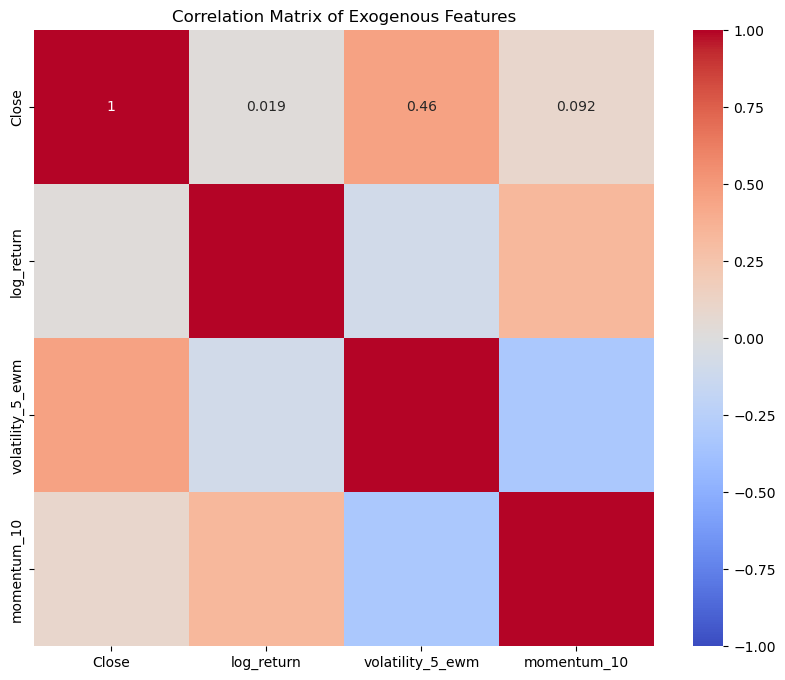

Close               1.000000
log_return          0.019304
volatility_5_ewm    0.459635
momentum_10         0.091721
Name: Close, dtype: float64


In [70]:
# Calculate the correlation matrix
correlation_matrix = df1[['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']].corr()

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Exogenous Features')
plt.show()

# Calculate the correlation between features and the target (Close price)
feature_target_corr = df1[['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']].corr()

# Display only the target's correlation with the other features
print(feature_target_corr['Close'])

In [72]:
# Saving dataframe to the Desktop to initiate trials with new features. 
df1.to_csv('C:/Users/nozom/OneDrive/Desktop/Preprocessing Pipelines/df_feat.csv', index=True)

### Winsorization

- An attempt to handle outliers and reduce volatility applying only winsorization, however LSTM models were still overfitting as observable in the winzo Log Returns NN's Notebook. Thus, winsorization will be perfomed on the raw data so as its features.

After the winsorization is applied, further EDA and correlation analysis will be performed to check the impact in the data.

In [75]:
# Creates a copy to have the original to compare 
df_winso_feat = df1.copy()

# Function to apply winsorization per year for each feature
def winsorize_year(df_winso_feat, features, lower_quantile=0.1, upper_quantile=0.9):
    # Loop through each feature and apply winsorization
    for feature in features:
        df_winso_feat[feature] = df_winso_feat.groupby('Year')[feature].transform(
            lambda x: x.clip(lower=x.quantile(lower_quantile), upper=x.quantile(upper_quantile))
        )
    return df_winso_feat

# List of features to apply winsorization
features = ['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']

# Apply winsorization to each feature per year
df_winso_feat = winsorize_year(df_winso_feat, features)

# Print a sample of the winsorized DataFrame
print(df_winso_feat.head())

            Year        Close  log_return  volatility_5_ewm  momentum_10
Date                                                                    
2014-01-28  2014  1845.048035    0.006122         25.926020   -46.380005
2014-01-29  2014  1845.048035   -0.007982         26.095101   -47.578040
2014-01-30  2014  1845.048035    0.008064         21.309648   -47.578040
2014-01-31  2014  1845.048035   -0.006486         18.363369   -47.578040
2014-02-03  2014  1845.048035   -0.007982         27.400342   -47.578040


In [76]:
# Select only the relevant columns to describe from df1 (before Winsorization)
before_winsor = df1[['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']].describe()

# Select the same columns from df_winso_feat (after Winsorization)
after_winsor = df_winso_feat[['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']].describe()

# Display both summaries to compare
print("Statistics Before Winsorization:")
print(before_winsor)

print("\nStatistics After Winsorization:")
print(after_winsor)

Statistics Before Winsorization:
             Close   log_return  volatility_5_ewm  momentum_10
count  2589.000000  2589.000000       2589.000000  2589.000000
mean   3014.529653     0.000380         31.312924    11.306790
std     899.277328     0.011035         25.242057   101.500239
min    1741.890015    -0.127652          3.177438  -732.020020
25%    2129.899902    -0.003533         14.027321   -23.039795
50%    2801.310059     0.000312         23.794287    19.119995
75%    3910.520020     0.005279         40.743908    58.709961
max    4796.560059     0.089683        236.990576   426.280029

Statistics After Winsorization:
             Close   log_return  volatility_5_ewm  momentum_10
count  2589.000000  2589.000000       2589.000000  2589.000000
mean   3016.714696     0.000604         30.135836    14.184280
std     893.497601     0.007324         21.422859    79.455815
min    1845.048035    -0.018635          5.422085  -263.019897
25%    2127.810059    -0.003216         14.202091   

The descriptive statistics shows that: 
- The index (Close) had minimal changes, where its minimun ranges from 1845 to 4668.
- Log returns have a different standard deviation (reduced from 0.01 to 0.007). Also, the feature presents a new range (min =  -0.12765, max = 0.08968)(min = -0.01863, max = 0.01874). Showing that the winsorization performed well on the feature.
- THe Volatility had a big impact from the approach, reducing its maximun value from 236 to 100.
- Momentum had the min/max adjusted (From: -732 / 426 To: -263 / 194), the standard deviation also reduced from 101 to 79. Thus, making the feature more stable.  

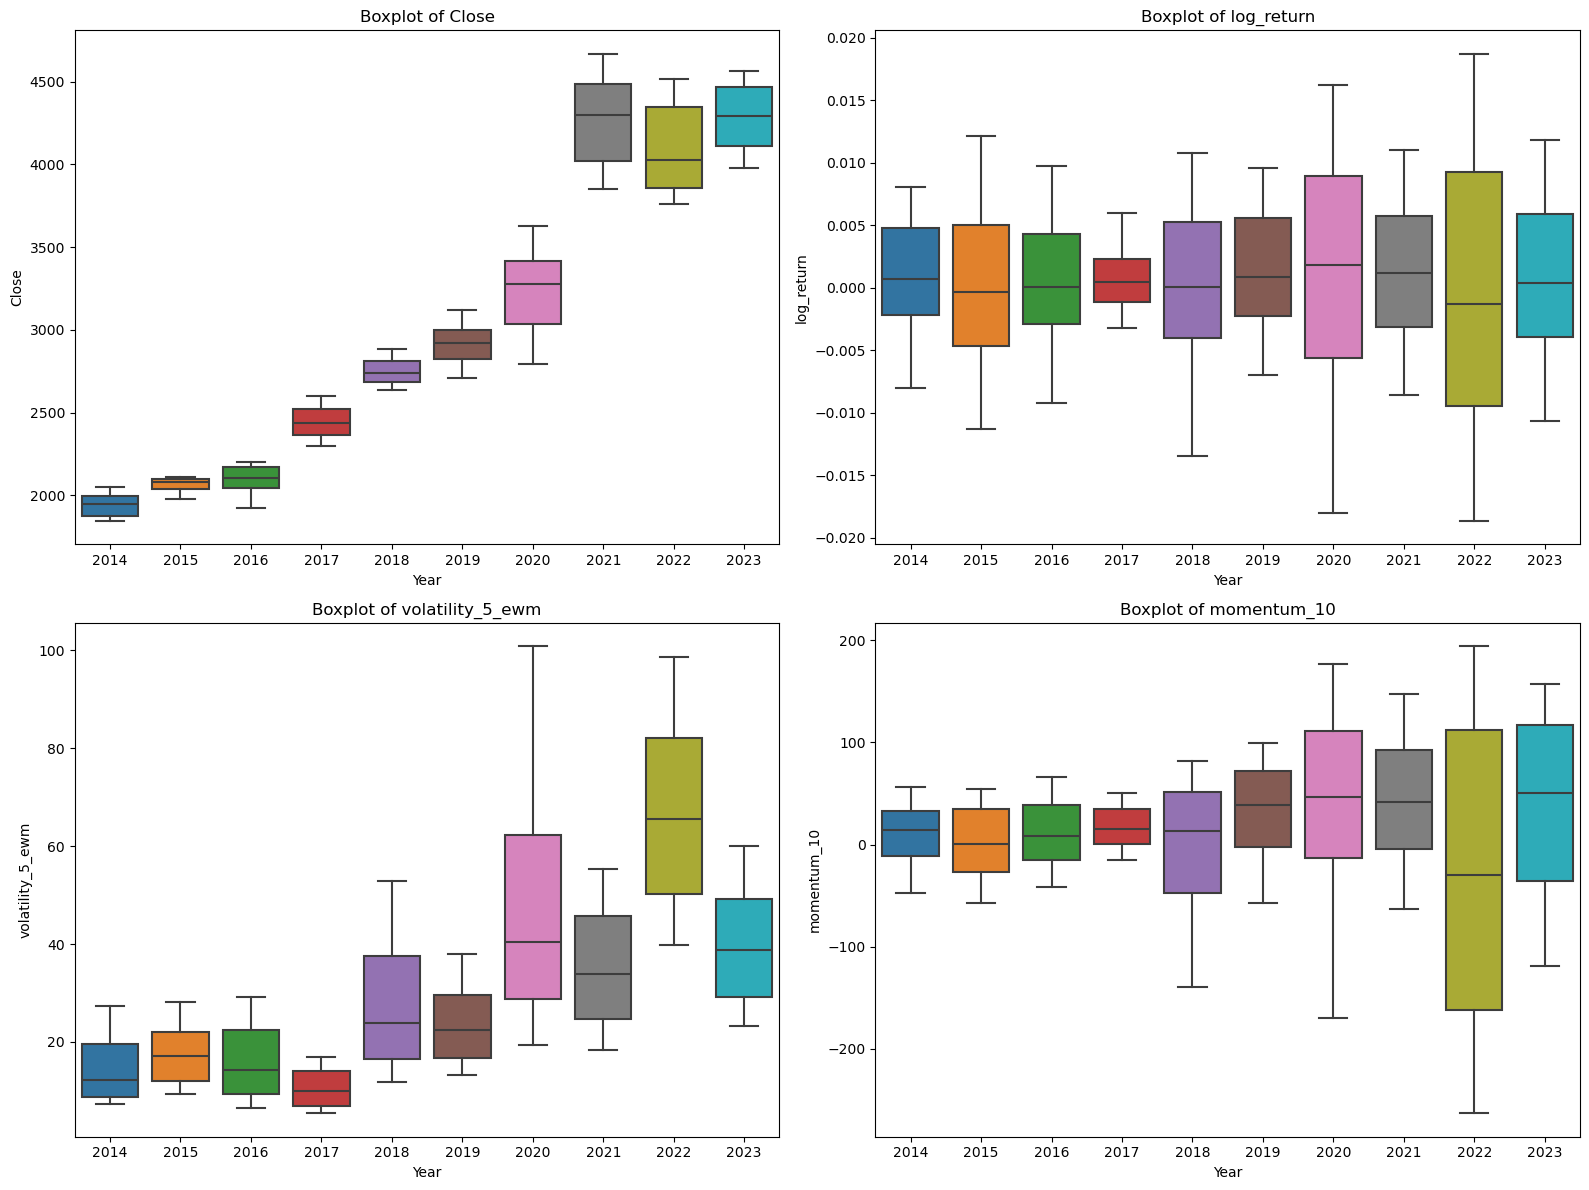

In [78]:
# List of features to check for outliers
features = ['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']

# Create boxplots for each feature
plt.figure(figsize=(16, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i) # 2x2 grid for 4 features
    sns.boxplot(data=df_winso_feat, x='Year', y=feature)
    plt.title(f'Boxplot of {feature}')
    
plt.tight_layout()
plt.show()

- The S&P500 Index had numerous outliers over the ten years period, especially during 2020 (huge spikes). After winsorization, the index did not suffered major changes at the boxplot nor the distribution,
- The Log Returns had a major impact regarding outliers, before the approach numerous were present, but after not only they were capped but also presents "better" distribution.
- The Volatility also had the outliers clipped and they are no longer present.
- The Momentum also had their outliers reduced.

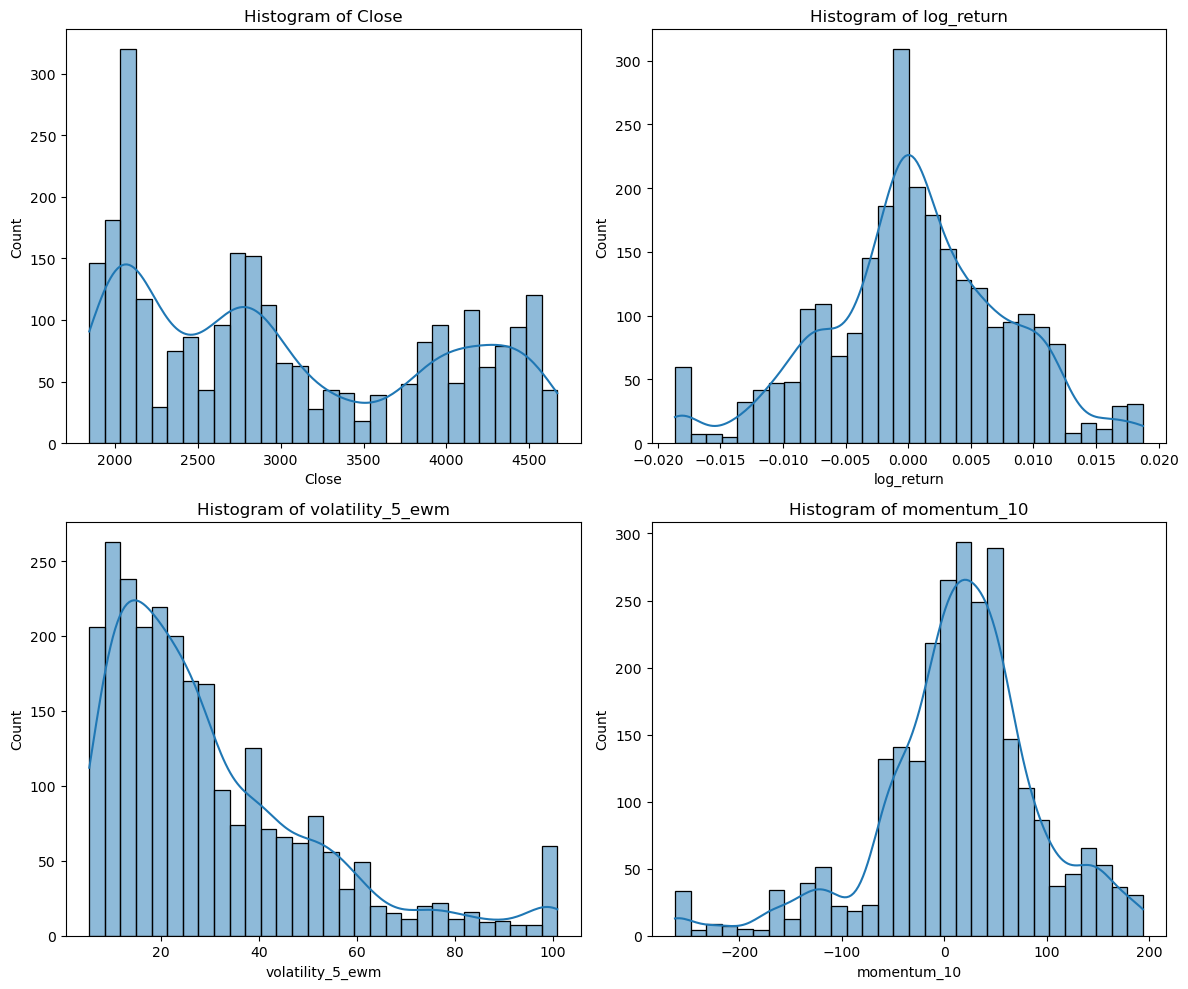

In [80]:
# List of features to plot histograms for
features = ['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']

# Plot histograms for each feature
plt.figure(figsize=(12, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)  # 2x2 grid for 4 features
    sns.histplot(df_winso_feat[feature], bins=30, kde=True)
    plt.title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()


- Apart from the Index that stayed relatively the same, the features had their extreme values clipped and turned their distribution less tailed. This could help the removal of noise. 

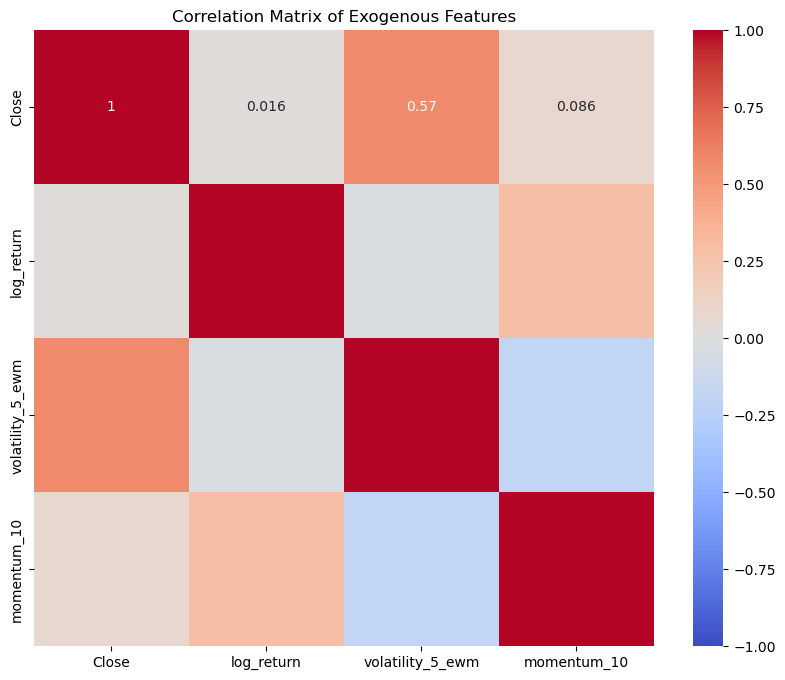

Close               1.000000
log_return          0.015727
volatility_5_ewm    0.574719
momentum_10         0.085781
Name: Close, dtype: float64


In [82]:
# Calculate the correlation matrix
correlation_matrix = df_winso_feat[['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']].corr()

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Exogenous Features')
plt.show()

# Calculate the correlation between features and the target (Close price)
feature_target_corr = df_winso_feat[['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']].corr()

# Display only the target's correlation with the other features
print(feature_target_corr['Close'])

- The technique slightly increased the correlation between volatility and the stock index. Thus, in general the correlation scores remained the same. 

In [84]:
# Create a DataFrame for features only
features = df_winso_feat[['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']]

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = features.columns
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print(vif)

            Feature       VIF
0             Close  4.835765
1        log_return  1.100364
2  volatility_5_ewm  4.668265
3       momentum_10  1.227224


- Winsorization reduced the outliers in the features and reduced the VIF scores, indicating that the approach reduced multicollinearity among the features.

**After a couple of trials with raw data and transformed data using different LSTM archtectures, the final perfomance was indicating overfitting, not generalizing well. Thus, it is hoped that feature engineering will aid the models to capture the nuance of the data and improve its performance.** 

In [86]:
# Saving dataframe to the Desktop to initiate trials with new features. 
df_winso_feat.to_csv('C:/Users/nozom/OneDrive/Desktop/Preprocessing Pipelines/df_winso_feat.csv', index=True)